CNN-based semantic segmentation of peat GRIPS
=========================================

The following notebook demonstrates applying a Convolutional Neural Net via the transfer learning method to map peat GRIPS/drains as requested within CEH. A lack of elevation data for all of the sites has resulted in the use of RGB aerial imagery and this more elaborate approach. 

## Libs/Code/Installation

**This is largely dependent on geospatial-learn (a lib I wrote) 
functions for file I/O, training & saving the CNN model and subsequent predicton on new data. 
Please install this as per the instructions [here](https://github.com/Ciaran1981/geospatial-learn).**

A lot of the boiler plate for CNN's with [pytorch](https://pytorch.org/) and geospatial data is
within the lib, particlarly [convnet.py](https://github.com/Ciaran1981/geospatial-learn/blob/master/geospatial_learn/convnet.py) for the main functions 
and [convutils.py](https://github.com/Ciaran1981/geospatial-learn/blob/master/geospatial_learn/convutils.py) for the ancillary stuff. I don't claim this to be an efficient/best way, but it may be of interest if unfamiliar. It all revolves around [numpy](https://numpy.org/), [gdal/ogr](https://gdal.org/) and pytorch.

**You will need a CUDA capable GPU(s) for this code to run.**

**Ensure you are running the correct kernel. Look at the top right  it should be [conda env:geolearn] (unless you called it something else) as seen in the top right.** 

**If not, Kernel > Change kernel > geolearn from the menu.** 


## The CNN model

### CNNs, semantic segmentation
CNNs rely on rectilinear patches (recall the myriad of picture naming ones on the internet) to learn a pattern corresponding to a particular class(es). The network learns different parts of the patch to build a hierarchical representation of the image. The type of CNN used here is of the semantic segmentation variety (essentially a per pixel classifier), where the pixel probabilities within the patch are used to demarcate the object of interest as opposed to simply saying it contains a class (or not). 

### CNNs, large-scale imagery
The CNN lib/model framework typically works on relatively small discrete images. Given the geo-spatial context and large images we are working with, we are required to chop our imagery up into pieces. These are in turn converted to tensor arrays as this is the format readily ingested by the libs typically used (in this case pytorch). Much of the underlying code is devoted to this sort of thing. I have chosen 256x256 pixels for reasons of raster I/O efficiency as well as it being a unit the Unet model likes, though you could go bigger/smaller. 

### Transfer learning/model 
As is usual with transfer learning, we fine tune a pre-trained model with our own set of training/classes (in this case a binary classification). This can be done with only the outer layers, freezing the inner model weights or tuning the entire model with a very fine learning rate.

As with many other studies, the use of the [UNet](https://arxiv.org/abs/1505.04597) architecture (originally devised for cell classification) seems like a logical choice for "planar-view" classification tasks and this application is no different. The UNet architexture is so-called due to the schematic appearence of the model structure taken from the orginal paper.

![Generalisation of CNN courtesy of google](pics/u-net-architecture.png)

The author provides a very good overview and video [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

It may be easier to think of these sorts of models in terms of the following illustration however **(Disclaimer;  I am simplifying and generalizing here!)**. A schematic of the CNN used is displayed below (from the publication on this research - Robb et al. 2023), where imagery is propagated through the network via a series of non-linear activation functions to produce a binary segmentation map. 

![Generalisation of CNN courtesy of google](pics/UnetNew.png)

The network connections are represented by the arrows linking the encoder and decoder segments. Each yellow
panel in the schematic represents a convolutional layer, with the feature depth therein annotated at the foot of each, with the max-pooling/up-sampling fraction to the right of these. 

From left to right, an input image is ingested, the encoder produces feature maps at each convolutional layer, of which the maximum response values are propagated to the next via a max-pooling operation (red panels). This process is analogous, to changing the emphasis from the spatial aspects of the image, to the class identity with depth in the network. The reverse is then applied via up-convolutions (blue panels) to reconstruct from the deepest feature map, eventually resulting in a soft-max-based probability map (pink panel), from which a per pixel mask is produced from a predefined threshold (Robb et al. 2023).


It is possible to mix and match encoder/decoders, which can enhance results depending on the task. In this case for example, we use a [resnet](https://en.wikipedia.org/wiki/Residual_neural_network) encoder, with the Unet architecture.  


In [1]:
from glob2 import glob
import os
from osgeo import gdal
from geospatial_learn.raster import rasterize, write_vrt
from geospatial_learn.convnet import *
from geospatial_learn.shape import extent2poly, polygonize
from geospatial_learn.convutils import maskblock,  image_grid, visualize_aug
from geospatial_learn import handyplots as hp
from tqdm import tqdm
from joblib import Parallel, delayed
from osgeo import gdal
import numpy as np
import albumentations as A

In [2]:
%matplotlib inline

## Part 1: file admin and prep

The datasets required for this reside on the CEH network and consist of a set of shapefiles of manually mapped GRIPS which will be used as training data. There is a corresponding set of aerial imaegry (each tile is 40x40k pixels) from which the fine tuning training will be extracted. The image tiles are called 'Square_A.tif, Square_B.tif etc.' and the training shapefiles correspond to this. The aerial images are located over areas of peat mire in Wales and are distributed quite widely. Despite being tiffs, these images appear to have undergone lossy compression (e.g. like a jpg) at some point.  


The following gets lists of all the files required, the rasterizes the training lines/polygons, saving them to a specific folder within the main dir


Replace paths with your own, where you have saved the respective data. 

In [ ]:
main_dir="path/to/work/dir"

os.mkdir(main_dir)

#the images
img_dir= '/location/of/image/tiles'
#the polys
poly_dir = 'polys'

# lists and sorting
tilelist = glob(os.path.join(img_dir, "*Square*.tif"))
tilelist.sort()

polylist = glob(os.path.join(poly_dir, "*.shp"))
polylist.sort()

# Output binary training masks
label_t = os.path.join(main_dir, 'LabelTiles')
if not os.path.isdir(label_t):
    os.mkdir(label_t)

For the sake of brevity the rasterization is done in parallel, though there seems to be a limit to the efficacy of this beyond 8 threads. 

In [ ]:
def rasterize_path(poly, tile, label_t):
    out_ras = os.path.join(label_t, os.path.split(poly)[1])
    out_ras = out_ras.replace(".shp", ".tif")
    rasterize(poly, tile, out_ras)
    return out_ras

# Tends to slow down much beyond 8 threads on my PC 
# (i have only 64gb of RAM & 32 threads), 
# if you have lots more RAM you could run it with more e.g. 13 threads being the
# max no of images
    
# no of threads - change according to what you have to work with
nt = 8
# joblib para....this will be memory intensive!
masklist = Parallel(n_jobs=nt, verbose=2)(delayed(rasterize_path)(
        p, t, label_t) for p, t in zip(polylist, tilelist))

## Part 2: Chips and training

CNNs rely on a rectilinear patch for training and output so we must extract these (referred to as chips from here-on) from the imagery. 

For each tile (the original 40x40k images), we gather the mask and corresponding image chips.
In this case the 'chip' is a 256 x 256 tile (could go bigger, but things will slow down...), so for each full-size image tile, we save only the areas with training masks, as this is what pytorch loader classes
will accept as input for the training. 

Training includes image augmentations as we have relatively few examples(1000s); 
where the existing images are manipulated to produce addtional training 
(flipping images around, cropping bits out etc.). The underlying solution to this uses [Albumentations](https://github.com/albumentations-team/albumentations) a library dedicated to this task. 

As mentioned, the training and model creation is based on transfer learning, 
where a pre-trained networks' weights are slightly adjusted for our own imagery,
which assumes there is a degree of similarity in the types of features 'learned' 
from imagery in general and the ones we are using.

Below are some example chips to illustrate some training samples as they are fed to the model. The images appear to have been lossily compressed at some point so features are not very clear!

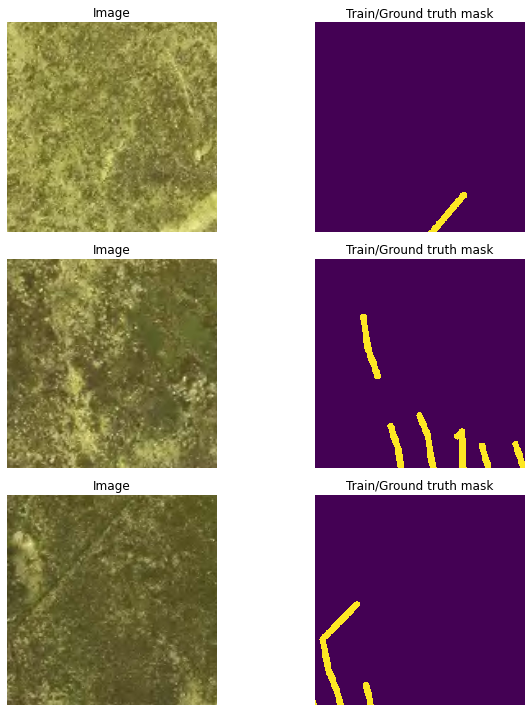

In [3]:
# Get the images
imgNms = glob('pics/img/*.tif')
imgNms.sort()
mskNms = glob('pics/msk/*.tif')
mskNms.sort()

# plot em
image_grid(imgNms, mskNms)

### Augmentations digression....

Even with transfer learning we still want a lot of training, which can be further 'augmented' by pixel/spatial transforms of our existing imagery, which in turn should improve our model performance.

Below is a quick example of augmentations on the above images. This is simply rotating the image randomly by 90 degrees, but the underlying code used later performs many of these as well as scaling/cropping. 


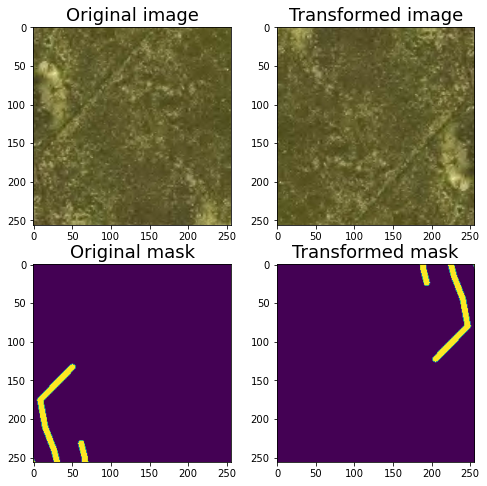

In [5]:
aug = A.RandomRotate90(p=1)

visualize_aug(aug, imgNms[2], mskNms[2], bands=[1,2,3])


Another example of augmentation is shift/scale/rotate, which is a random combo of several augs. 

There are many possibilities, though for remotely sensed data, nondestructive spatial augmentations are enough. 

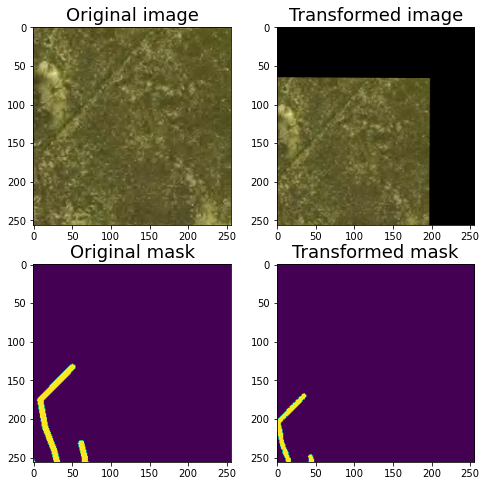

In [9]:
aug = A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.5, shift_limit=0.3,
                                  p=1, border_mode=0)

visualize_aug(aug, imgNms[2], mskNms[2], bands=[1,2,3])

### Back to the task 

First we make a directory for the training imagery and masks then collect it.

This is not the quickest but ensures the training data is all in one place despite the scattered nature of the input imagery.

In [ ]:
outdir = 'SemanticSegTest/traintest'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# The default chip size in the function is 256 so not an explict param here.
# As well as saving the masks and image chips, the function returns their file 
# paths ,should they be required later
mskout, imgout = collect_train(masklist, tilelist, outdir)

### Now to train the model....

The function accepts a dict to define the parameters in addition to the function ones, most of which are self explanatory. Ultimately more time should be spent with parameters etc. but....

Of particular note are: 

```python 
lr: 0.0001
```
Which is the the learning rate, the increment of gradient descent at which the CNN is pushed. This is always a balance between getting stuck in local minima or missing the best route down.....this could be further reduced to 0.00001.

```python
epochs: 300
```
300 is the number of model iterations to go through before completing training (this is overkill....). If the valid/test loss creeps up eventually, the model could well be overfitting....

The directory in which the training was saved is the first parameter (```outdir```).

In [ ]:
params={'model': 'Unet',
        'encoder': 'resnet34',
        'in_channels': 3,
        'classes' : 1,
        "lr": 0.0001,
        "device": "cuda",
        "batch_size": 16,
        "num_workers": 2,
        "epochs": 300}

modelpth =  ('unet300.pth')

train_semseg_binary(outdir, modelpth=modelpth, params=params)

## Part 3: Predict & save the outputs

Finally prediction. I have included the code to predict the entire dataset, but given we have trained on 60-70% of it this will of course give us flattering results. 

**If you wish to skip this look at the file included in the CNNresults directory in QGIS**


In [ ]:
outlist = [f.replace(".tif", "_ditches.tif") for f in tilelist]

for t,o in zip(tilelist, outlist):
    semseg_pred(t, modelpth,  o, 'resnet34') 

# polygonise the outputs....
shplist = [o.replace(".tif", ".shp") for o in outlist]
for o, s in zip(outlist, shplist):
    polygonize(o, s)    

### Wales dataset -  qualitative results

The results appear to show reasonable mapping of larger ditches though much ommission remains. There is also a great deal of commision error, with both superficially similar features (perhaps understandable) and spurious ones. 

**Possible arm-waving reasons**:

**Image compression/resolution**

Inspection of these images suggests lossy compression, recovering the original full-resoltuion imagery and hence greater clarity may have improved results...

**Ditches do not present a uniform appearence**

Unlike the succeeding Scottish data, the ditch water is not always clearly visible, which also explains the myriad of false positves where there is a linear feature of some sort.  

## Part 4: Predict on the new Scottish dataset based on our model

**There are some ditches mapped in the area, so it makes sense to use these and create a new model, which turns out to work rather well**

The training polygons occur over 2 aerial imagery grid areas which are merged into larger images for training collection only. 

This will of course only run if you create and populate folders with relevant imagery.

- NC85, NC95 should contain the Next map jpgs from those directories

- polydir should contain the 5m buffered Bighouse data labelled by OS tile

In [ ]:
#workspace
main_dir='scotsemseg'
os.mkdir(main_dir)

imgdir = 'merged'
os.mkdir(imgdir)

# merge the wee images....
# Not sure what needs to be changed to use /vrts so will stick with tifs
inlist85 = glob('NC85/*.jpg')
_merge(names=inlist85, out_file=os.path.join(imgdir, 'nc85.tif'), separate=0)

inlist95 = glob('NC95/*.jpg')
_merge(names=inlist95, out_file=os.path.join(imgdir, 'nc95.tif'), separate=0)

### We follow largely the same procedure as before to rasterize the data in order to collect training chips

In [ ]:
#the images
tilelist= [os.path.join(imgdir, 'nc85.tif'),
           os.path.join(imgdir, 'nc95.tif')]
#the polys dir
poly_dir = ('trainpolys')
# the polylist
# Found 2m buffer didn't cover due to way data was digitised, hence 5m
# must get texture within and adjacent
polylist= glob(os.path.join(poly_dir, '*buf5m.shp'))
polylist.sort()

# Output binary training masks
label_t = os.path.join(main_dir, 'LabelTiles')
if not os.path.isdir(label_t):
    os.mkdir(label_t)

# rasterise and return the path so it can be used later
def rasterize_path(poly, tile, label_t):
    out_ras = os.path.join(label_t, os.path.split(poly)[1])
    out_ras = out_ras.replace(".shp", ".tif")
    rasterize(poly, tile, out_ras)
    return out_ras

masklist = []
for p,r in tqdm(zip(polylist, tilelist)):
    oot = rasterize_path(p, r, label_t)
    masklist.append(oot)

### Training

Training is exactly as before - 300 epochs - this is too much, but could improve by tidying up the training data & parameter tuning...

In [ ]:
mskout, imgout = collect_train(masklist, tilelist, outdir)

# train and create a model

# dict of model params
# 300 epochs is probably overkill, but this will get us to ~99% accuracy on the
# training data
# If the validation loss starts creeping back up after a long time, the model
# is likely overfitting the training data. 
params={'model': 'Unet',
        'encoder': 'resnet34',
        'in_channels': 3,
        'classes' : 1,
        "lr": 0.0001,
        "device": "cuda",
        "batch_size": 16,
        "num_workers": 2,
        "epochs": 300}

mdldir = os.path.join(main_dir, 'models')
if not os.path.exists(mdldir):
    os.mkdir(mdldir)
modelpth =  os.path.join(mdldir,'smp300.pth')

best_model, logs = train_semantic_seg(outdir, modelpth=modelpth,
                                      params=params, activation='sigmoid',
                                      plot_score=True, nt=-1))


In [ ]:
log #print the test set results

**Test results indicate an IOU score of around 79%**

This is of course must be considered in the context of a relatively small train/valid/test split of data. Training for longer will likely increase the accuracy (IoU), though there is always the danger of over-fitting.

### Predict ditches on the new imagery

Now we can predict on the new data pending some quick file admin. Prior to this I made virtual rasters of all the input imagery rather than merging all of it into large images. I assume you will make your own. To do so run a command like this in each Next Map aerial imagery directory. 

```bash
gdalbuildvrt nd04.vrt *.jpg

```
Then you can replace the file paths I have below as they were on my computer.


In [ ]:
#to save merging them all....bit of a mess of files....
vrtlist = ['NC/NC94/nc94.vrt',
           'NC/NC95/nc95.vrt',
           'NC/NC84II/NC84/nc84.vrt',
           'NC/NC85II/NC85/nc85.vrt',
           'NC/NC83/nc83.vrt',
           'NC/NC73/nc73.vrt',
           'NC/NC74/nc74.vrt',
           'NC/ND04/nd04.vrt']


# stop repeating code.....
mapdir = os.path.join(main_dir, 'outputs')
if not os.path.exists(mapdir):
    os.mkdir(mapdir)

# output paths
outlist = []
for v in vrtlist:
    pth = os.path.split(v)[1]
    outlist.append(os.path.join(mapdir,
                                pth.replace(".vrt", "_ditches.tif"))) 
# The prediction
for t,o in zip(vrtlist, outlist):
    semseg_pred(t, modelpth,  o, 'resnet34') 
                 

### Results

**Polygonise the outputs then take a look in QGIS**

In [ ]:
# polygonise the outputs....
shplist = [o.replace(".tif", ".shp") for o in outlist]
for o, s in zip(outlist, shplist):
    polygonize(o, s)

Once you have messed about with symbology etc, you should end up with something that looks like the following figure from the paper.

![Generalisation of CNN courtesy of google](pics/Peat_Results_map_A2F.png)